# Getting started with Swift-XRT

## Learning Goals

This tutorial will teach you how to:
- Identify and download Swift observations of a particular source (we use the recurrent nova **T Pyx** to demonstrate).
- Prepare Swift X-ray Telescope (XRT) data for scientific use, producing 'level 2' cleaned event lists.
- Generate Swift-XRT data products, including:
    - Exposure maps
    - Images
    - Spectra
    - Light curves
- Perform a simple spectral analysis.

## Introduction

This notebook is intended to introduce you to the use of data taken by the Swift mission's X-ray
Telescope (XRT) instrument and to provide a template or starting point for performing your own analysis.

Swift is a high-energy mission designed for extremely fast reaction times to transient high-energy
phenomena, particularly Gamma-ray Bursts (GRBs). The Burst Alert Telescope (BAT) instrument has a very large
field-of-view (FoV; ~2 steradians), and when it detects a GRB, it will typically start to slew in ~10 seconds. That
means that Swift's other two instruments, XRT and the Ultra-violet Optical Telescope (UVOT), both with much smaller
FoVs, can be brought to bear on the GRB quickly.

Though designed with GRBs in mind, Swift's quick reaction times and wide wavelength coverage make it useful for many
other transient phenomena, 'recurrent novae' for instance.

Novae are multi-wavelength transients powered by a thermonuclear runaway on the surface of an accreting white
dwarf. At early times during the eruption (the first month or two), the X-ray emission is relatively hard and
produced thermally by shock-heated gas inside the ejecta. This hard X-ray emission can be faint and is not always
detectable with Swift-XRT (or any other X-ray telescope for that matter). As the nova evolves, the ejecta thins out, and
we get a view of the white dwarf's surface, where there is residual nuclear burning. This nuclear burning emits
predominantly in the far UV/soft X-ray bands and produces a bright super-soft X-ray transient, often modeled as a
blackbody, sometimes with some residual hard X-rays from shock-heated gas remaining. This component is usually
visible with Swift-XRT for reasonably nearby Galactic novae like T Pyx, and the XRT count rates can vary anywhere from
under 0.01 ct s$^{-1}$ to ~300 ct s$^{-1}$.

Using a recurrent nova as an example, we will take you, from first principles, through the process of identifying
Swift-XRT observations of an object of interest, downloading and processing the data, generating common X-ray data
products, and performing a simple spectral analysis. Work undertaken by [Chomiuk et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...788..130C/abstract) inspired many
of the demonstrations in this notebook.

We will use the Python interface to HEASoft (HEASoftPy) throughout this notebook.

### Inputs

- The name of the source (**T Pyx**) we want to investigate.
- Discovery time of T Pyx's sixth historical outburst (**55665 MJD**).

### Outputs

- X-ray data products (images, exposure maps, spectra, light curves, etc.) for our selection of Swift observations.
- Visualizations of Swift-XRT images, centered on T Pyx.
- Visualizations of T Pyx Swift-XRT spectra, as well as fitted spectral models.

### Runtime

As of 31st October 2025, this notebook takes ~16 minutes to run to completion on Fornax using the 'Default Astrophysics' image and the 'medium' server with 16GB RAM/ 4 cores.

## Imports

In [1]:
import contextlib
import glob
import multiprocessing as mp
import os
from copy import deepcopy
from typing import Tuple, Union
from warnings import warn

import heasoftpy as hsp
import matplotlib.pyplot as plt
import numpy as np
import xspec as xs
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.units import Quantity
from astropy.visualization import PowerStretch
from astroquery.heasarc import Heasarc
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from xga.imagetools.misc import pix_deg_scale
from xga.products import EventList, Image

/opt/envs/heasoft/lib/python3.12/site-packages/xga/utils.py:39: DeprecationWarning: The XGA 'find_all_wcs' function should be imported from imagetools.misc, in the future it will be removed from utils.
  warn(message, DeprecationWarning)
/opt/envs/heasoft/lib/python3.12/site-packages/xga/utils.py:619: UserWarning: SAS_DIR environment variable is not set, unable to verify SAS is present on system, as such all functions in xga.sas will not work.
  warn("SAS_DIR environment variable is not set, unable to verify SAS is present on system, as such "


## Global Setup

### Functions

In [2]:
def process_swift_xrt(
    cur_obs_id: str, out_dir: str, rel_coord: SkyCoord
) -> Tuple[str, Union[str, hsp.core.HSPResult], bool]:
    """
    A wrapper for the HEASoftPy xrtpipeline task, which prepares data taken by the
    Swift-XRT instrument for scientific use; the wrapper is primarily to enable the
    use of multiprocessing.

    The XRT pipeline has three stages, which, broadly speaking, do the following:
        1. Stage 1 assembles and calibrates initial unfiltered event lists.
        2. Stage 2 performs standard screening of events to produce
            'cleaned' (nominally ready for scientific use) event lists.
        3. Stage 3 generates standard data products, though fine-grained control over
            the outputs is not possible, so we do not use this stage (instead we call
            xrtproducts directly in another function).

    :param str cur_obs_id: The ObsID of the Swift observation to be processed.
    :param str out_dir: Path to the directory in which to save the
        output of the pipeline.
    :param SkyCoord rel_coord: Central coordinate of the source of interest
    :return: A tuple containing the processed ObsID, the log output of the
        pipeline, and a boolean flag indicating success (True) or failure (False).
    :rtype: Tuple[str, Union[str, hsp.core.HSPResult], bool]
    """

    # Ensures we exit at the second step, before any standard products are generated.
    xrt_pipe_exit = 2

    # Makes sure the specified output directory exists.
    os.makedirs(out_dir, exist_ok=True)

    # Using dual contexts, one that moves us into the output directory for the
    #  duration, and another that creates a new set of HEASoft parameter files (so
    #  there are no clashes with other processes).
    with contextlib.chdir(out_dir), hsp.utils.local_pfiles_context():

        xrt_pipeline = hsp.HSPTask("xrtpipeline")

        og_par_names = deepcopy(xrt_pipeline.par_names)
        og_par_names.pop(og_par_names.index("mode"))
        xrt_pipeline.par_names = og_par_names

        src_ra = float(rel_coord.ra.value)
        src_dec = float(rel_coord.dec.value)

        # The processing/preparation stage of any X-ray telescope's data is the most
        #  likely to go wrong, and we use a Python try-except as an automated way to
        #  collect ObsIDs that had an issue during processing.
        try:
            out = xrt_pipeline(
                indir=os.path.join(ROOT_DATA_DIR, cur_obs_id),
                outdir=".",
                steminputs=f"sw{cur_obs_id}",
                exitstage=xrt_pipe_exit,
                srcra=src_ra,
                srcdec=src_dec,
                chatter=TASK_CHATTER,
                clobber=True,
                datamode="PC",
                obsmode="POINTING",
            )
            task_success = True

        except hsp.HSPTaskException as err:
            task_success = False
            out = str(err)

    return cur_obs_id, out, task_success


def gen_xrt_expmap(
    evt_path: str, out_dir: str, att_path: str, hd_path: str
) -> hsp.core.HSPResult:
    """
    A wrapper for the HEASoftPy implementation of the xrtexpomap task, which generates
    exposure maps for Swift-XRT observations.

    :param str evt_path: Path to the cleaned Swift-XRT event list file.
    :param str out_dir: Path to the directory in which to save the output of the tool.
    :param str att_path: Path to the attitude file for the observation.
    :param str hd_path: Path to the Swift-XRT housekeeping file for the observation.
    :return: A HEASoftPy result object containing the log output of the xrtexpomap task.
    :rtype: hsp.core.HSPResult
    """

    with contextlib.chdir(out_dir), hsp.utils.local_pfiles_context():
        out = hsp.xrtexpomap(
            infile=evt_path,
            outdir=out_dir,
            attfile=att_path,
            hdfile=hd_path,
            chatter=TASK_CHATTER,
            clobber=True,
        )

    return out


def gen_xrt_im_spec(
    evt_path: str,
    out_dir: str,
    sreg_path: str,
    breg_path: str,
    exp_map_path: str,
    att_path: str,
    hd_path: str,
    lc_lo_lim: Quantity = Quantity(30, "chan"),
    lc_hi_lim: Quantity = Quantity(1000, "chan"),
) -> Tuple[str, str]:
    """
    A Python wrapper for the HEASoft xrtproducts tool, which generates light curves,
    images, and spectra from cleaned Swift-XRT event lists.

    :param str evt_path: Path to the cleaned Swift-XRT event list file.
    :param str out_dir: Path to the directory in which to save the output of the tool.
    :param str sreg_path: Path to the region file defining the source region.
    :param str breg_path: Path to the region file defining the background region.
    :param str exp_map_path: Path to the exposure map for the XRT observation
    :param str att_path: Path to the attitude file for the observation.
    :param str hd_path: Path to the Swift-XRT housekeeping file for the observation.
    :param Quantity lc_lo_lim: Lower channel limit for light curve generation.
    :param Quantity lc_hi_lim: Upper channel limit for light curve generation.
    :return: String versions of the stdout and stderr captured from
        the run of xrtproducts.
    :rtype: Tuple[str, str]
    """

    if lc_lo_lim > lc_hi_lim:
        raise ValueError(
            "The lower channel limit must be less than or equal to the upper "
            "channel limit."
        )

    if isinstance(lc_lo_lim, Quantity):
        lc_lo_lim = lc_lo_lim.astype(int).value
    if isinstance(lc_hi_lim, Quantity):
        lc_hi_lim = lc_hi_lim.astype(int).value

    with contextlib.chdir(out_dir), hsp.utils.local_pfiles_context():
        out = hsp.xrtproducts(
            infile=evt_path,
            outdir=".",
            regionfile=sreg_path,
            bkgextract="yes",
            bkgregionfile=breg_path,
            chatter=TASK_CHATTER,
            clobber="yes",
            expofile=exp_map_path,
            attfile=att_path,
            hdfile=hd_path,
            pilow=lc_lo_lim,
            pihigh=lc_hi_lim,
            noprompt=True,
        )

    return out

### Constants

In [3]:
# The name of the recurrent nova we will analyze in this tutorial
SRC_NAME = "T Pyx"
# The MJD discovery time of the 6th historical outburst of the nova
DISC_TIME = Time("55665", format="mjd")

# Controls the verbosity of all HEASoftPy tasks
TASK_CHATTER = 3

# The nominal mapping between Swift-XRT channel and energy
EV_PER_CHAN = Quantity(10, "eV/chan")

### Configuration

In [4]:
# ------------- Configure global package settings --------------
# Raise Python exceptions if a heasoftpy task fails
# TODO Remove once this becomes a default in heasoftpy
hsp.Config.allow_failure = False

# Set up the method for spawning processes.
mp.set_start_method("fork", force=True)
# --------------------------------------------------------------

# ------------- Setting how many cores we can use --------------
NUM_CORES = None
total_cores = os.cpu_count()

if NUM_CORES is None:
    NUM_CORES = total_cores
elif not isinstance(NUM_CORES, int):
    raise TypeError(
        "If manually overriding 'NUM_CORES', you must set it to an integer value."
    )
elif isinstance(NUM_CORES, int) and NUM_CORES > total_cores:
    raise ValueError(
        f"If manually overriding 'NUM_CORES', the value must be less than or "
        f"equal to the total available cores ({total_cores})."
    )
# --------------------------------------------------------------

# -------------- Set paths and create directories --------------
# Set up the path of the directory into which we will download Swift data
if os.path.exists("../../../_data"):
    ROOT_DATA_DIR = os.path.join(os.path.abspath("../../../_data"), "Swift", "")
else:
    ROOT_DATA_DIR = "Swift/"

# Whatever the data directory is, make sure it is absolute.
ROOT_DATA_DIR = os.path.abspath(ROOT_DATA_DIR)

# Make sure the download directory exists.
os.makedirs(ROOT_DATA_DIR, exist_ok=True)

# Setup path and directory into which we save output files from this example.
OUT_PATH = os.path.abspath("Swift_output")
os.makedirs(OUT_PATH, exist_ok=True)
# --------------------------------------------------------------

***

## 1. Finding and downloading Swift observations of T Pyx

Our first task is to determine which Swift observations are relevant to the source
that we are interested in, the recurrent nova T Pyx.

We are going in with the knowledge that T Pyx has been observed by Swift, but of
course there is no guarantee that _your_ source of interest has been, so this is
an important exploratory step.

### Identifying the Swift observation summary table

HEASARC maintains tables that contain information about every observation taken by
each of the missions in its archive. We will use Swift's table to find observations
that should be relevant to our source.

The name of the Swift observation summary table is 'swiftmastr', but as you may not
know that a priori, we demonstrate how to identify the correct table for a given
mission.

Using the AstroQuery Python module (specifically this Heasarc object), we list all
catalogs that are a) related to Swift, and b) are flagged as 'master' (meaning the
summary table of observations). This should only return one catalog for any
mission you pass to 'keywords':

In [5]:
catalog_name = Heasarc.list_catalogs(master=True, keywords="swift")[0]["name"]
catalog_name

np.str_('swiftmastr')

### What are the coordinates of the target?

To search for relevant observations, we have to know the coordinates of our
source. The astropy module allows us to look up a source name in CDS' Sesame name
 resolver and retrieve its coordinates.

```{hint}
You could also set up a SkyCoord object directly, if you already know the coordinates.
```

In [6]:
src_coord = SkyCoord.from_name(SRC_NAME)
# This will be useful later on in the notebook, for functions that take
#  coordinates as an astropy Quantity.
src_coord_quant = Quantity([src_coord.ra, src_coord.dec])
src_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (136.1729423, -32.37986193)>

### Searching for Swift observations of T Pyx

Now that we know which catalog to search, and the coordinates of our source, we use
AstroQuery to retrieve those lines of the summary table that are within some radius
of the source coordinate.

Each mission's observation summary table has its own default search radius, normally
based on the size of the telescope's FoV.

Defining a default radius for missions that have multiple instruments with very
different FoVs (like Swift) can be challenging, so it is always a good idea to check
what the default value is:

In [7]:
Heasarc.get_default_radius(catalog_name)

<Quantity 25. arcmin>

That default radius suits our purposes, but if it hadn't, then we could have overridden
it by passing a different value to the `radius` keyword argument.

We run the query and receive a subset of the master table containing information about
the relevant observations. The returned table is then sorted by ascending start time,
which will make our lives easier later in the notebook when we examine how T Pyx has
changed over time.

In [8]:
swift_obs = Heasarc.query_region(src_coord, catalog_name)

# We sort by start time, so the table is in order of ascending start
swift_obs.sort("start_time", reverse=False)

swift_obs

name,obsid,ra,dec,start_time,processing_date,xrt_exposure,uvot_exposure,bat_exposure,archive_date,__row
,,deg,deg,d,d,s,s,s,d,
object,object,float64,float64,float64,float64,float64,float64,float64,int32,object
TPyx,00031968001,136.15226,-32.37080,55665.587349537,57643.0,2597.30600,0.00000,2616.00000,55676,130422
TPyx,00031968002,136.14748,-32.36878,55666.7291666667,57643.0,1201.15300,0.00000,1218.00000,55677,130432
TPyx,00031968003,136.14294,-32.36096,55667.7388888889,57829.0,1474.82100,0.00000,1492.00000,55678,130520
TPyx,00031968004,136.09599,-32.36940,55668.7347222222,57643.0,1060.73900,0.00000,1077.00000,55679,130428
TPyx,00031968005,136.14678,-32.36484,55669.7458333333,57829.0,1438.27800,0.00000,1456.00000,55680,130496
TPyx,00031968006,136.14076,-32.37281,55670.6833333333,57829.0,2404.49000,0.00000,2438.00000,55681,130414
TPyx,00031968007,136.09743,-32.37885,55671.4797106481,57644.0,1011.84600,0.00000,1159.00000,55682,130333
TPyx,00031968008,136.16624,-32.38262,55672.6215162037,57644.0,252.47500,253.30500,600.00000,55683,130266


### Cutting down the Swift observations for this tutorial

The table we just retrieved shows that T Pyx has been observed by Swift many times, but
in order to shorten the run time of this demonstration, we're going to select a subset of the
available observations.

We select observations that were taken in a period of between 142 and 149 days after
the discovery of T Pyx's sixth outburst, a time in which it was particularly X-ray
bright.

In [9]:
# Defining an Astropy Time object, to match the Time object we defined
#  to hold the discovery time, in the global setup section.
obs_times = Time(swift_obs["start_time"], format="mjd")

# Simply subtract the discovery time from the observation times to get the delta
obs_day_from_disc = (obs_times - DISC_TIME).to("day")

# Make a dictionary of that information with ObsIDs as keys, which will make
#  some plotting code neater later on in the notebook
obs_day_from_disc_dict = {
    oi: obs_day_from_disc[oi_ind] for oi_ind, oi in enumerate(swift_obs["obsid"])
}

Now we'll apply the time window constraints by creating a boolean array that can be
applied to the retrieved observation table as a mask:

In [10]:
sel_mask = (obs_day_from_disc > Quantity(142, "day")) & (
    obs_day_from_disc < Quantity(149, "day")
)

The mask is applied to the original table of relevant observations, and we also read
out our selected ObsIDs into another variable, for later use:

In [11]:
cut_swift_obs = swift_obs[sel_mask]
rel_obsids = np.array(cut_swift_obs["obsid"])

cut_swift_obs

name,obsid,ra,dec,start_time,processing_date,xrt_exposure,uvot_exposure,bat_exposure,archive_date,__row
,,deg,deg,d,d,s,s,s,d,
object,object,float64,float64,float64,float64,float64,float64,float64,int32,object
TPyx,00031968059,136.20108,-32.38330,55807.7458333333,57660.0,1132.55700,1070.21100,1500.00000,55818,130265
TPyx,00032089001,136.04758,-32.31409,55807.7513888889,57660.0,3269.49300,3078.11900,3019.00000,55818,130458
TPyx,00031968060,136.15998,-32.38590,55809.6173611111,57660.0,1020.44500,960.60400,1294.00000,55820,130255
TPyx,00032089002,136.04691,-32.31299,55809.6229050926,57660.0,2017.86600,1858.87000,1839.00000,55820,130463
TPyx,00031968061,136.22223,-32.37604,55811.4979166667,57660.0,1294.37800,1238.56600,1800.00000,55822,130349
TPyx,00032089004,136.04593,-32.31546,55811.5048611111,57660.0,3414.31100,3268.16000,2993.00000,55822,130454
TPyx,00031968062,136.16252,-32.38602,55813.8319444444,57660.0,937.09900,898.66900,1200.00000,55824,130253
TPyx,00032089005,136.05578,-32.31443,55813.8388888889,57660.0,2326.41500,2231.70600,2150.00000,55824,130457


To put them into context, we plot the selected time-window-limited subset of relevant
observations, and all the other relevant observations, on a figure showing the
nominal Swift-XRT exposure time against the time since the discovery of T Pyx's
sixth outburst.

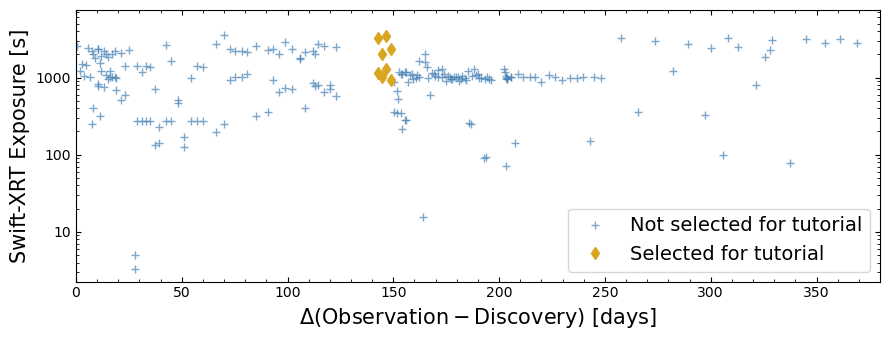

In [12]:
plt.figure(figsize=(9, 3.5))

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.plot(
    obs_day_from_disc,
    swift_obs["xrt_exposure"],
    "+",
    color="steelblue",
    alpha=0.7,
    label="Not selected for tutorial",
)
plt.plot(
    obs_day_from_disc[sel_mask],
    cut_swift_obs["xrt_exposure"],
    "d",
    color="goldenrod",
    label="Selected for tutorial",
)

plt.yscale("log")

plt.xlim(0, 380)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.xlabel(r"$\Delta(\rm{Observation-Discovery})$ [days]", fontsize=15)
plt.ylabel(r"Swift-XRT Exposure [s]", fontsize=15)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Downloading the selected Swift observations

We've settled on the observations that we're going to use during the course of this
tutorial and now need to actually download them. The easiest way to do this is to
use another feature of the AstroQuery `Heasarc` object, which will take the table
of chosen observations and identify 'data links' for each of them.

The data links describe exactly where the particular data can be downloaded from - for
HEASARC data the most relevant places would be the HEASARC FTP server and the [HEASARC
Amazon Web Services (AWS) S3 bucket](https://registry.opendata.aws/nasa-heasarc/).

In [13]:
data_links = Heasarc.locate_data(cut_swift_obs)
data_links

ID,access_url,sciserver,aws,content_length,error_message
,,,,byte,
object,object,str40,str53,int64,object
ivo://nasa.heasarc/swiftmastr?130253,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2011_09//00031968062/,/FTP/swift/data/obs/2011_09/00031968062/,s3://nasa-heasarc/swift/data/obs/2011_09/00031968062/,9989972,
ivo://nasa.heasarc/swiftmastr?130255,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2011_09//00031968060/,/FTP/swift/data/obs/2011_09/00031968060/,s3://nasa-heasarc/swift/data/obs/2011_09/00031968060/,11146423,
ivo://nasa.heasarc/swiftmastr?130265,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2011_09//00031968059/,/FTP/swift/data/obs/2011_09/00031968059/,s3://nasa-heasarc/swift/data/obs/2011_09/00031968059/,16683297,
ivo://nasa.heasarc/swiftmastr?130349,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2011_09//00031968061/,/FTP/swift/data/obs/2011_09/00031968061/,s3://nasa-heasarc/swift/data/obs/2011_09/00031968061/,33950072,
ivo://nasa.heasarc/swiftmastr?130454,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2011_09//00032089004/,/FTP/swift/data/obs/2011_09/00032089004/,s3://nasa-heasarc/swift/data/obs/2011_09/00032089004/,134191346,
ivo://nasa.heasarc/swiftmastr?130457,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2011_09//00032089005/,/FTP/swift/data/obs/2011_09/00032089005/,s3://nasa-heasarc/swift/data/obs/2011_09/00032089005/,72037009,
ivo://nasa.heasarc/swiftmastr?130458,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2011_09//00032089001/,/FTP/swift/data/obs/2011_09/00032089001/,s3://nasa-heasarc/swift/data/obs/2011_09/00032089001/,134506155,
ivo://nasa.heasarc/swiftmastr?130463,https://heasarc.gsfc.nasa.gov/FTP/swift/data/obs/2011_09//00032089002/,/FTP/swift/data/obs/2011_09/00032089002/,s3://nasa-heasarc/swift/data/obs/2011_09/00032089002/,97760516,


Passing the data links to the `Heasarc.download_data` function, and setting the
`ROOT_DATA_DIR` variable as the output directory, will download the Swift data to
the desired location.

This approach will download the entire data directory for a given Swift
observation, which will include BAT and UVOT instrument files that are not relevant
to this tutorial.

In [14]:
Heasarc.download_data(data_links, "aws", ROOT_DATA_DIR)

INFO: Downloading data AWS S3 ... [astroquery.heasarc.core]
INFO: Enabling anonymous cloud data access ... [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/swift/data/obs/2011_09/00031968062/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/swift/data/obs/2011_09/00031968060/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/swift/data/obs/2011_09/00031968059/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/swift/data/obs/2011_09/00031968061/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/swift/data/obs/2011_09/00032089004/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/swift/data/obs/2011_09/00032089005/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/swift/data/obs/2011_09/00032089001/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/swift/data/obs/2011_09/00032089002/ [astroquery.heasarc.core]


```{note}
We choose to download the data from the HEASARC AWS S3 bucket, but you could
pass 'heasarc' to acquire data from the FTP server. Additionally, if you are working
on SciServer, you may pass 'sciserver' to use the pre-mounted HEASARC dataset.
```

### What do the downloaded data directories contain?

In [15]:
glob.glob(os.path.join(ROOT_DATA_DIR, rel_obsids[0], "") + "*")

['/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/auxil',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/log',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/uvot',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/bat',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt']

In [16]:
glob.glob(os.path.join(ROOT_DATA_DIR, rel_obsids[0], "xrt", "") + "**/*")

['/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/event/sw00031968059xwtw2st_cl.evt.gz',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/event/sw00031968059xpcw3po_cl.evt.gz',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/event/sw00031968059xwtw2st_uf.evt.gz',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/event/sw00031968059xwtw2sl_cl.evt.gz',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/event/sw00031968059xpcw3po_uf.evt.gz',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/event/sw00031968059xwtw2sl_ufre.evt.gz',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/event/sw00031968059xwtw2sl_uf.evt.gz',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/event/sw00031968059xwtw2st_ufre.evt.gz',
 '/home/jovyan/projects/heasarc-tutorials/_data/Swift/00031968059/xrt/products/sw00031968059x_skim.gif',
 '/home/jovyan/proj

## 2. Processing the Swift-XRT data

Though the Swift observations directories we downloaded already contain cleaned XRT
event lists and pre-generated images, it is generally recommended that you reprocess
Swift data yourself.

Reprocessing ensures that the latest versions of the preparation tools have
been applied to your data.

### Running the Swift XRT pipeline

The software required to reprocess Swift-XRT observations is made available as part
of the HEASoft package. There are quite a few [Swift-XRT specific](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/xrt.html)
HEASoft tools, many of which are used as part of data processing, but a convenient
processing pipeline ([xrtpipeline](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/xrtpipeline.html))
means that we don't have to call the steps individually.

The pipeline is made up of three steps, with the user able to choose which step they
wish to start and stop at. Per the xrtpipeline documentation, the steps perform the
following processing steps:

Stage 1:
- Hot pixel identification for photon-counting mode data.
- Bad pixel identification for photon-counting and windowed-timing mode data.
- Corrects housekeeping exposure times (TIME and ENDTIME columns) for timing mode frames.
- Transforms coordinates for photon-counting, windowed-timing, and imaging mode data files.
- Bias subtraction for photon-counting and imaging mode data.
- Calculation of photon arrival times, and event recognition for timing mode data.
- Screening on event GTIs to erase piled-up frames and partially exposed events for photo-diode mode data.
- Event grade assignment for photon-counting and timing mode data.
- Calculation of the PI for photon-counting, windowed-timing, and photo-diode mode data.

Stage 2:
- Screening of the calibrated events produced in Stage 1 by applying conditions on a set of parameters. The screening is performed using GTIs obtained by applying conditions to housekeeping parameters specific to the instrument, and on attitude and orbit related quantities, a screening for bad pixels, and a constraints on acceptable event grades.

Stage 3:
- Generating products for scientific analysis using the 'xrtproducts' task.

The HEASoftPy Python package provides a convenient interface to all HEASoft tasks, and
we will use it to run the Swift-XRT processing pipeline. Additionally, we take
advantage of the fact that multicore CPUs are now essentially ubiquitous, and we
can perform parallel runs of xrtpipeline on individual observations. This significantly
reduces the time it takes to process all the observations.

Swift-XRT can be operated in different data modes, but for the purposes of this tutorial
we will focus only on the 'photon counting' (PC) mode, where XRT records the
position, energy, and arrival time of each event. From those data we can eventually
make images, light curves, and spectra. Other modes are more specialized, and beyond
the scope of this tutorial.

Likewise, Swift has different 'observation modes' (pointed, slew, and settling) - we
are only going to process and use the pointed data.

We set up a multiprocessing pool, and use `starmap` to call the `process_swift_xrt`
function with a different set of arguments for each ObsID - if there are more
observations than there are cores available, then the pool will manage
the allocation of tasks to cores. The data and observation modes are set within
our wrapper function.

The `process_swift_xrt` function is defined in the 'Global Setup' section of this
notebook, as we do not wish to interrupt the flow of this demonstration - you should
examine it to see how we call the HEASoftPy xrtpipeline task.

Our wrapper function also includes some error handling, meaning that if the processing
of an observation fails for some reason, we can identify that observation and remove
it from the list of relevant observations.

In [17]:
with mp.Pool(NUM_CORES) as p:
    arg_combs = [[oi, os.path.join(OUT_PATH, oi), src_coord] for oi in rel_obsids]
    pipe_result = p.starmap(process_swift_xrt, arg_combs)

xrt_pipe_problem_ois = [all_out[0] for all_out in pipe_result if not all_out[2]]
rel_obsids = [oi for oi in rel_obsids if oi not in xrt_pipe_problem_ois]

xrt_pipe_problem_ois

/opt/envs/heasoft/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=808) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


[]

```{warning}
In this demonstration we set xrtpipeline to exit at ***stage 2***, which is before
the generation of X-ray data products. That is because we will run the xrtproducts
task ourselves to give us more control over the outputs.
```

## 3. Generating Swift-XRT data products

As we chose to stop the Swift-XRT processing pipeline at the second stage, we must
now generate the X-ray data products that we want. Our primary reason for stopping
the pipeline before this step is that we want to specify source and background
regions ourselves, using region files.

We will create the images, light curves, spectra, and supporting files that we want
using the HEASoftPy interface to the xrtproducts task, but will also use other
HEASoft tools to generate Swift-XRT exposure maps, and to group the spectra.

### Preparing for product generation

It is useful at this stage to set up a variable to define the path to the **clean**
event lists we output in the previous section. As we did not pass xrtpipeline
arguments that modify the name of the event lists, they will have the default
structure.

In [18]:
evt_path_temp = os.path.join(OUT_PATH, "{oi}/sw{oi}xpcw3po_cl.evt")

Now we create basic region files that define where the source and background
spectra should be extracted from. In this case the source region is a circle, centered
on the source coordinates, with a 180" radius, and the background region is an annulus
around that source region, with a 240" radius and a 390" radius.

You might well wish to define more complex regions, particularly if there are bright
sources close to the source you wish to analyze, and you would like to exclude them.

In [19]:
src_pos = src_coord.to_string("hmsdms", sep=":").replace(" ", ", ")

src_reg_path = os.path.join(OUT_PATH, "src.reg")

src_region = f'circle({src_pos}, 180")'
with open(src_reg_path, "w") as fp:
    fp.write("fk5\n")
    fp.write(src_region)

bck_reg_path = os.path.join(OUT_PATH, "bck.reg")

bgd_region = f'annulus({src_pos}, 240", 390")'
with open(bck_reg_path, "w") as fp:
    fp.write("fk5\n")
    fp.write(bgd_region)

### Generating exposure maps

The portion of xrtproducts that generates an ARF to accompany the source spectrum can
use an exposure map to weight the PSF corrections applied to each portion of the
extraction region. As the product generation pipeline does not create its own exposure
maps, we will use the HEASoft xrtexpomap tool to make them here.

Some extra files are required by xrtexpomap, particularly the attitude file (which
records the spacecraft attitude information throughout the observation) and the XRT
housekeeping file (which contains detailed information about the state of
the instrument).

```{warning}
Swift observation directories contain multiple attitude files, created in different
ways. For some Swift processing tasks it is **essential** that the same attitude
file used to create the event list is used - see
[this resource for more information](https://www.swift.ac.uk/analysis/xrt/digest_sci.php#att).
The header of the EVENTS table in the event file can identify the correct attitude file.
```

In [20]:
# We need to determine exactly which attitude file to use for each observation
att_files = {}
for oi in rel_obsids:
    cur_evts = EventList(evt_path_temp.format(oi=oi))
    att_ident = cur_evts.event_header["ATTFLAG"]
    if att_ident == "100":
        att_temp = "sw{oi}sat.fits.gz"
    elif att_ident == "110":
        att_temp = "sw{oi}pat.fits.gz"
    elif att_ident in ["111", "101"]:
        att_temp = "sw{oi}uat.fits.gz"

    att_files[oi] = os.path.join(ROOT_DATA_DIR, "{oi}/auxil", att_temp).format(oi=oi)

hd_file_temp = os.path.join(ROOT_DATA_DIR, "{oi}/xrt/hk/sw{oi}xhd.hk.gz")

We will once again run the XRT HEASoft tasks for our observations in parallel so that
we can generate multiple exposure maps at once and speed up this notebook. Just like
when we ran the xrtpipeline, here we have defined a wrapper function for the HEASoftPy
interface to xrtexpomap, which can be found in the 'Global Setup' section of this
notebook.

In [21]:
with mp.Pool(NUM_CORES) as p:
    arg_combs = [
        [
            evt_path_temp.format(oi=oi),
            os.path.join(OUT_PATH, oi),
            att_files[oi],
            hd_file_temp.format(oi=oi),
        ]
        for oi in rel_obsids
    ]

    exp_result = p.starmap(gen_xrt_expmap, arg_combs)

### Generating light curves, images, and spectra

We are finally ready to create light curves, images, and spectra from our Swift-XRT
observations of T Pyx! The same multiprocessing setup used for xrtpipeline
and xrtexpomap is implemented here, with a wrapper function defined in the 'Global
Setup' section of this notebook.

Setting up a variable that defines the path to the exposure maps that we just
generated, as we need to pass them to the xrtproducts task:

In [22]:
exp_map_temp = os.path.join(OUT_PATH, "{oi}/sw{oi}xpcw3po_ex.img")

Now we run the xrtproducts task, again parallelizing so that products for different
observations are produced simultaneously. This tool will always produce full-FoV images
in the 0.5-10.0 keV energy band, with a pixel size of 2.36".

Whilst you cannot control the image energy band, you **can** specify PI channel limits for
light curves, using the `pilow` (default is 30) and `pihigh` (default is 1000)
arguments. For Swift-XRT (*remember that different telescopes/instruments have
different channel-to-energy mappings*) that corresponds to 0.3-10.0 keV. We
decide (somewhat arbitrarily) to generate light curves within the 0.5-2.5 keV energy
band.

In [23]:
lc_lo_en = (Quantity(0.5, "keV") / EV_PER_CHAN).to("chan")
lc_hi_en = (Quantity(2.5, "keV") / EV_PER_CHAN).to("chan")

with mp.Pool(NUM_CORES) as p:

    arg_combs = [
        [
            evt_path_temp.format(oi=oi),
            os.path.join(OUT_PATH, oi),
            src_reg_path,
            bck_reg_path,
            exp_map_temp.format(oi=oi),
            att_files[oi],
            hd_file_temp.format(oi=oi),
        ]
        for oi in rel_obsids
    ]

    prod_result = p.starmap(gen_xrt_im_spec, arg_combs)

### Grouping the spectra

Finally, we will group the spectra we just generated. Grouping essentially combines
spectral channels until some minimum quality threshold is reached; in this case a
minimum of one count per grouped channel. We use the HEASoft `ftgrouppha` tool to do
this, once again through HEASoftPy.

The reason we're doing this is that the Cash statistic, which is very commonly used for
statistical checks during X-ray spectral fitting, requires at least one count per
grouped channel (or bin) to be valid. The Cash statistic is well suited to X-ray
analysis, as more often than not, our data are quite Poissonian.

Once again we create variables that define the paths to relevant data products:

In [24]:
sp_temp = os.path.join(OUT_PATH, "{oi}/sw{oi}xpcw3posr.pha")
bsp_temp = os.path.join(OUT_PATH, "{oi}/sw{oi}xpcw3pobkg.pha")

grp_sp_temp = os.path.join(OUT_PATH, "{oi}/sw{oi}xpcw3posr_grp.pha")

Now we run the grouping tool - though this time we do not parallelize the task, as
the grouping process is very fast, and we wish to demonstrate how you use a HEASoftPy
function directly. Though remember to look at the Global Setup section of this notebook
to see how we call HEASoftPy tools in the wrapper functions used to parallelize those
tasks.

If you are dealing with significantly more observations than we use for this
demonstration, we do recommend that you parallelize this grouping step as we have
the other processing steps in this notebook.

In [25]:
for oi in rel_obsids:
    sp_path = sp_temp.format(oi=oi)
    bsp_path = bsp_temp.format(oi=oi)

    hsp.ftgrouppha(
        infile=sp_path,
        outfile=grp_sp_temp.format(oi=oi),
        grouptype="min",
        groupscale=1,
    )

```{hint}
Though we used a minimum count per grouped channel metric, ftgrouppha supports various
other ways of binning a spectrum; e.g. uniform bin size, minimum signal-to-noise, and
other 'optimised' binning algorithms (see the
[ftgrouppha help page for more information](https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/help/ftgrouppha.html)).
```

## 4. Examining the new Swift-XRT images

When doing any sort of archival X-ray analysis (or indeed any kind of astrophysical
work), we think it is important that you visually examine your data products. This
serves both as a simple validity check and as a first chance to identify any
interesting features in your data.

In [26]:
im_temp = os.path.join(OUT_PATH, "{oi}/sw{oi}xpcw3po_sk.img")

Here we create a simple figure with a separate panel for each Swift-XRT image we
generated, making it easy to examine them all at once. In Section 1 we ordered the
table of observations relevant to T Pyx by start time and placed the
relevant ObsIDs into an array. We can now loop through that array and be assured that
the images we plot will be in order of their observation's start time.

To make the process a little easier, we make use of a Python module called
X-ray: Generate and Analyse (XGA); amongst other things, it implements Python classes
designed to make interacting with X-ray data products much easier. In this case we
will make use of a convenience function of the `Image` class that produces a
visualization of the data.

First, we load all our Swift-XRT images into XGA Image instances and store them in
a dictionary, with the ObsID as the key (makes them easier to access later):

In [27]:
ims = {
    oi: Image(
        path=im_temp.format(oi=oi),
        obs_id=oi,
        instrument="XRT",
        stdout_str="",
        stderr_str="",
        gen_cmd="",
        lo_en=Quantity(0.5, "keV"),
        hi_en=Quantity(10, "keV"),
    )
    for oi in rel_obsids
}

The XGA images we just set up have a `.view()` method, that produces a
publication-ready visualization of the image. The `.view()` method takes a number of
arguments that control the appearance of and information on the visualization.

Also included is a `get_view()` method, which returns a populated matplotlib axis,
rather than immediately showing the image. This is useful if you wish to make
more complex modifications or additions to the figure, and also if you wish to embed
the visualization in a larger figure.

As we wish to produce a multi-panel plot of our Swift-XRT observations, we will use
the `get_view()` method. We will also use the `Image` class's coordinate conversion
functionality to manually zoom in on a 3x3' region centered on T Pyx:

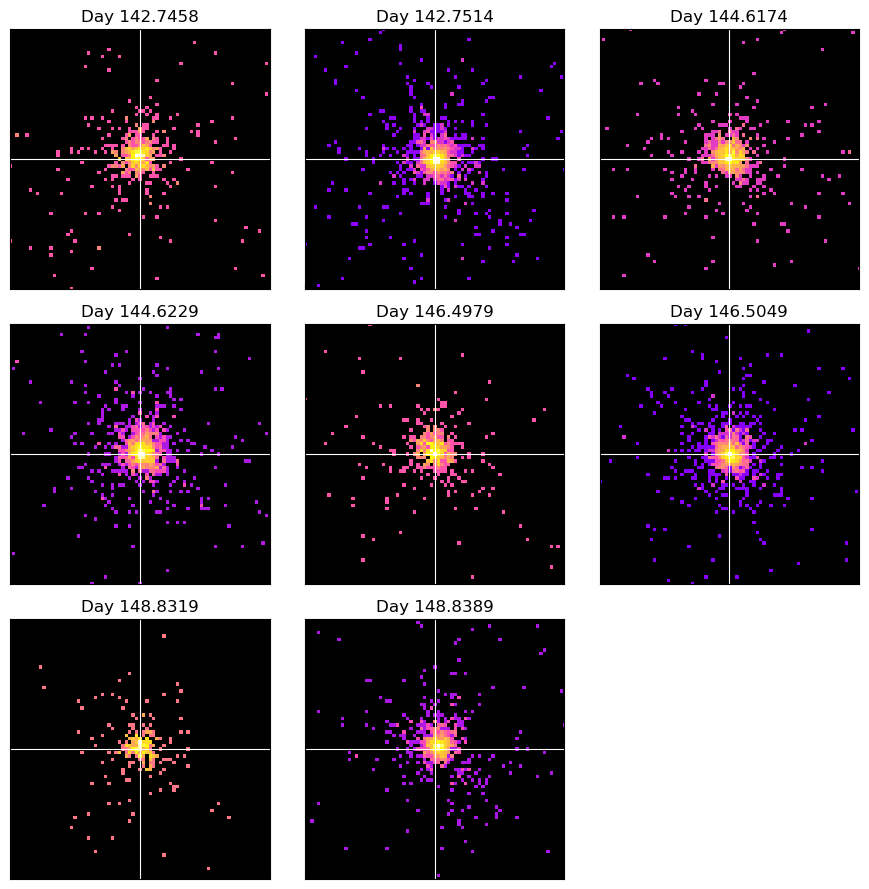

In [28]:
num_ims = len(ims)
num_cols = 3
num_rows = int(np.ceil(num_ims / num_cols))

fig_side_size = 3
reg_side_size = Quantity(3, "arcmin")

fig, ax_arr = plt.subplots(
    ncols=num_cols,
    nrows=num_rows,
    figsize=(fig_side_size * num_cols, fig_side_size * num_rows),
)
plt.subplots_adjust(wspace=0.02, hspace=0.02)

ax_ind = 0
for ax_arr_ind, ax in np.ndenumerate(ax_arr):
    if ax_ind >= num_ims:
        ax.set_visible(False)
        continue

    cur_oi = rel_obsids[ax_ind]
    cur_im = ims[cur_oi]

    pd_scale = pix_deg_scale(src_coord_quant, cur_im.radec_wcs)
    pix_half_size = ((reg_side_size / pd_scale).to("pix") / 2).astype(int)

    pix_coord = cur_im.coord_conv(src_coord_quant, "pix")
    x_lims = [
        (pix_coord[0] - pix_half_size).value,
        (pix_coord[0] + pix_half_size).value,
    ]
    y_lims = [
        (pix_coord[1] - pix_half_size).value,
        (pix_coord[1] + pix_half_size).value,
    ]

    day_title = "Day {}".format(obs_day_from_disc_dict[cur_im.obs_id].round(4).value)

    cur_im.get_view(
        ax,
        src_coord_quant,
        custom_title=day_title,
        zoom_in=True,
        manual_zoom_xlims=x_lims,
        manual_zoom_ylims=y_lims,
    )

    ax_ind += 1

plt.tight_layout()
plt.show()

Also included in the XGA `Image` class is a way of overlaying the contents of a region
file. We demonstrate the simplest possible case of this here by passing the path to
the source region file we created earlier, and overlaying that one region.

It is also possible to pass a list of region objects from the
[astropy-affiliated `regions` module](https://astropy-regions.readthedocs.io/en/stable/).

We also demonstrate how custom 'stretches' (the default is a LogStretch) can be
applied to the image, by passing an astropy `PowerStretch` instance.

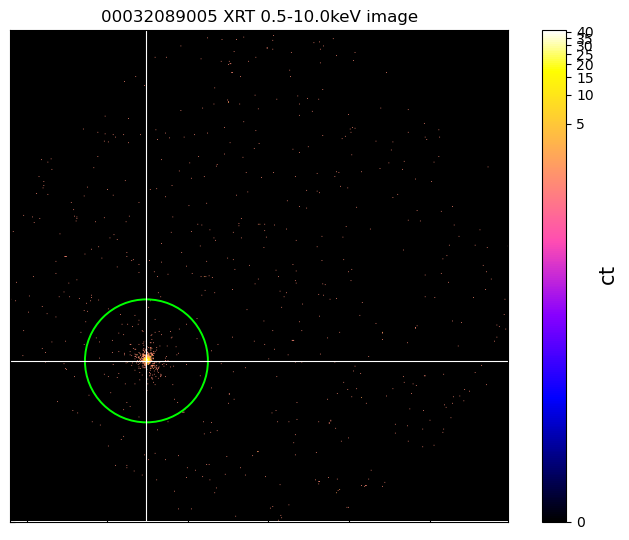

In [29]:
cur_im = ims[rel_obsids[-1]]

cur_im.regions = src_reg_path
cur_im.view(
    src_coord_quant,
    zoom_in=True,
    view_regions=True,
    figsize=(7, 5.5),
    stretch=PowerStretch(0.1),
)

## 5. Loading and fitting spectra with pyXspec

We now wish to fit a model to the spectra that we just generated, which we hope will
give us some physical insight into T Pyx's sixth historical outburst!

In this demonstration we will use the Python interface to the XSPEC spectral
fitting package, [pyXspec](https://heasarc.gsfc.nasa.gov/docs/software/xspec/python/html/index.html).

Our demonstration of using pyXspec for spectral fitting will be of moderate complexity, but
please note that XSPEC (and by extension pyXspec) is a very powerful tool, with a great
deal of flexibility. It is not possible for us to demonstrate every aspect of pyXspec in
this notebook. We encourage you to explore the [pyXspec documentation](https://heasarc.gsfc.nasa.gov/docs/software/xspec/python/html/index.html), and
[this list of available models](https://heasarc.gsfc.nasa.gov/docs/software/xspec/manual/node128.html).

This demonstration will include fitting a multi-component model to our Swift-XRT
spectra, both individually and using XSPEC's joint-fitting functionality.

We first define path variables for the ARF and RMF files that accompany and support our
spectra:

In [30]:
arf_temp = os.path.join(OUT_PATH, "{oi}/sw{oi}xpcw3posr.arf")
rmf_temp = os.path.join(OUT_PATH, "{oi}/swxpc0to12s6_20110101v014.rmf")

### Configuring PyXspec

Now we configure some behaviors of XSPEC/pyXspec:
- The ```chatter``` parameter is set to zero to reduce printed output during fitting (note that some XSPEC messages are still shown).
- We inform XSPEC of the number of cores we have available, as some XSPEC methods can be paralleled.
- We tell XSPEC to use the Cash statistic for fitting (the reason we grouped our spectra earlier).

In [31]:
xs.Xset.chatter = 0

# XSPEC parallelisation settings
xs.Xset.parallel.leven = NUM_CORES
xs.Xset.parallel.error = NUM_CORES
xs.Xset.parallel.steppar = NUM_CORES

# Other xspec settings
xs.Plot.area = True
xs.Plot.xAxis = "keV"
xs.Plot.background = True
xs.Fit.statMethod = "cstat"
xs.Fit.query = "no"
xs.Fit.nIterations = 500

### Reading spectra into pyXspec

The first step is to load each Swift-XRT observation's source spectrum into
pyXspec, and then to point pyXspec towards the background spectrum, ARF, and RMF files.

In some cases manually specifying the locations of background, ARF, and RMF files
isn't necessary, as their paths can be embedded in a FITS header of the source
spectrum file.

Every spectrum is read into a different XSPEC data group, and once loaded, we tell
XSPEC to ignore any spectrum channels that are not within the **0.3-7.0 keV** energy
range. Choices like this are driven by the effective energy range of the
instrument (XRT data below 0.3 keV are not considered trustworthy, for instance), as
well as by your own analysis needs.

T Pyx is not a particularly 'hard' (i.e. high-energy) X-ray source, and there is very
little signal above 7 keV. As such, we may get better results if we exclude those
higher energies from consideration during spectral fitting. We could even move the
upper energy limit down further if we found that our spectral fits were not successful.

We also explicitly exclude any spectral channels that have been marked as 'bad', which
could have happened in the processing/generation of our X-ray data products.

In [32]:
# Clear out any previously loaded datasets and models
xs.AllData.clear()
xs.AllModels.clear()

# Iterating through all the ObsIDs
with tqdm(
    desc="Loading Swift-XRT spectra into pyXspec", total=len(rel_obsids)
) as onwards:
    for oi_ind, oi in enumerate(rel_obsids):
        data_grp = oi_ind + 1

        # Loading in the spectrum - making sure they all have different data groups
        xs.AllData(f"{data_grp}:{data_grp} " + grp_sp_temp.format(oi=oi))
        spec = xs.AllData(data_grp)
        spec.response = rmf_temp.format(oi=oi)
        spec.response.arf = arf_temp.format(oi=oi)
        spec.background = bsp_temp.format(oi=oi)

        spec.ignore("**-0.3 7.0-**")
        onwards.update(1)

# Ignore any channels that have been marked as 'bad'
# This CANNOT be done on a spectrum-by-spectrum basis, only after all spectra
#  have been declared
xs.AllData.ignore("bad")

Loading Swift-XRT spectra into pyXspec: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


### Fitting a model to all spectra individually

Somewhat following the example of [Chomiuk et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...788..130C/abstract), we will fit
a model with two additive components, a blackbody and a bremsstrahlung continuum, and
an absorption component. Unlike [Chomiuk et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...788..130C/abstract), we do
not include a Gaussian component to model the O VIII emission line.

Another model difference is that they used the `tbnew` plasma absorption model, whereas
we use `tbabs`.

Our approach is not entirely comparable to that of [Chomiuk et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...788..130C/abstract), as they
generated week-averaged Swift-XRT spectra, not spectra from individual
observations; creating combined Swift-XRT spectra is outside the scope of this demonstration,
however.

By default, a model for each spectrum will be set up, with like parameters in each
model 'tied' together; so the column density for each model will vary
together, for instance, as will every other component.

Once we set reasonable parameter start values for the first model (the model assigned
to the first spectrum loaded in), they will also be assigned to all other models.

We initially want to fit each spectrum completely separately, as we know that recurrent
novas are, by their nature, variable with time; it would be interesting to know if
the parameters of our spectral model vary over the course of these
observations (around a week). As such, we 'untie' all the model parameters, making
them completely independent:

In [33]:
# Set up the pyXspec model
xs.Model("tbabs*(bb+brems)")

# Setting start values for model parameters
xs.AllModels(1).setPars({1: 1, 2: 0.1, 4: 1.0, 3: 1, 5: 1})

for mod_id in range(2, len(rel_obsids) + 1):
    xs.AllModels(mod_id).untie()

To run the spectral fits, we can call the pyXspec `Fit.perform()` function:

In [34]:
xs.Fit.perform()

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.
tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross 

We will quickly print the current values of all model parameters - though the 'chatter'
level we specified earlier has to be temporarily relaxed in order to see the
XSPEC output.

It is obvious from a glance that each model was individually fitted, as like
parameters for each spectrum have different values:

In [35]:
xs.Xset.chatter = 10
xs.AllModels.show()
xs.Xset.chatter = 0

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.

Parameters defined:
Model TBabs<1>(bbody<2> + bremss<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
                           Data group: 1
   1    1   TBabs      nH         10^22    0.109146     +/-  3.09077E-02  
   2    2   bbody      kT         keV      4.98714E-02  +/-  3.88626E-03  
   3    2   bbody      norm                5.89566E-03  +/-  4.23737E-03  
   4    3   bremss     kT         keV      1.40213      +/-  0.269462     
   

#### Visualizing individually fitted spectra

Examining the spectra and their fit lines is a good way to see how well the models
are representing the data, so we will make another multi-panel figure to view them
all at once.

The pyXspec module has some built-in plotting capabilities, but we will instead
extract the information necessary to build our own figure with matplotlib directly; it
gives us much more control over the appearance of the output:

In [36]:
xs.Plot()

spec_plot_data = {}
fit_plot_data = {}
for oi_ind, oi in enumerate(rel_obsids):
    data_grp = oi_ind + 1

    spec_plot_data[oi] = [
        xs.Plot.x(data_grp),
        xs.Plot.xErr(data_grp),
        xs.Plot.y(data_grp),
        xs.Plot.yErr(data_grp),
    ]
    fit_plot_data[oi] = xs.Plot.model(data_grp)

Creating the figure, we can immediately see that the spectra for
observations *00031968060* and *00032089002* appear to show an excess of
low-energy (<0.5 keV) X-ray emission, compared to the other spectra.

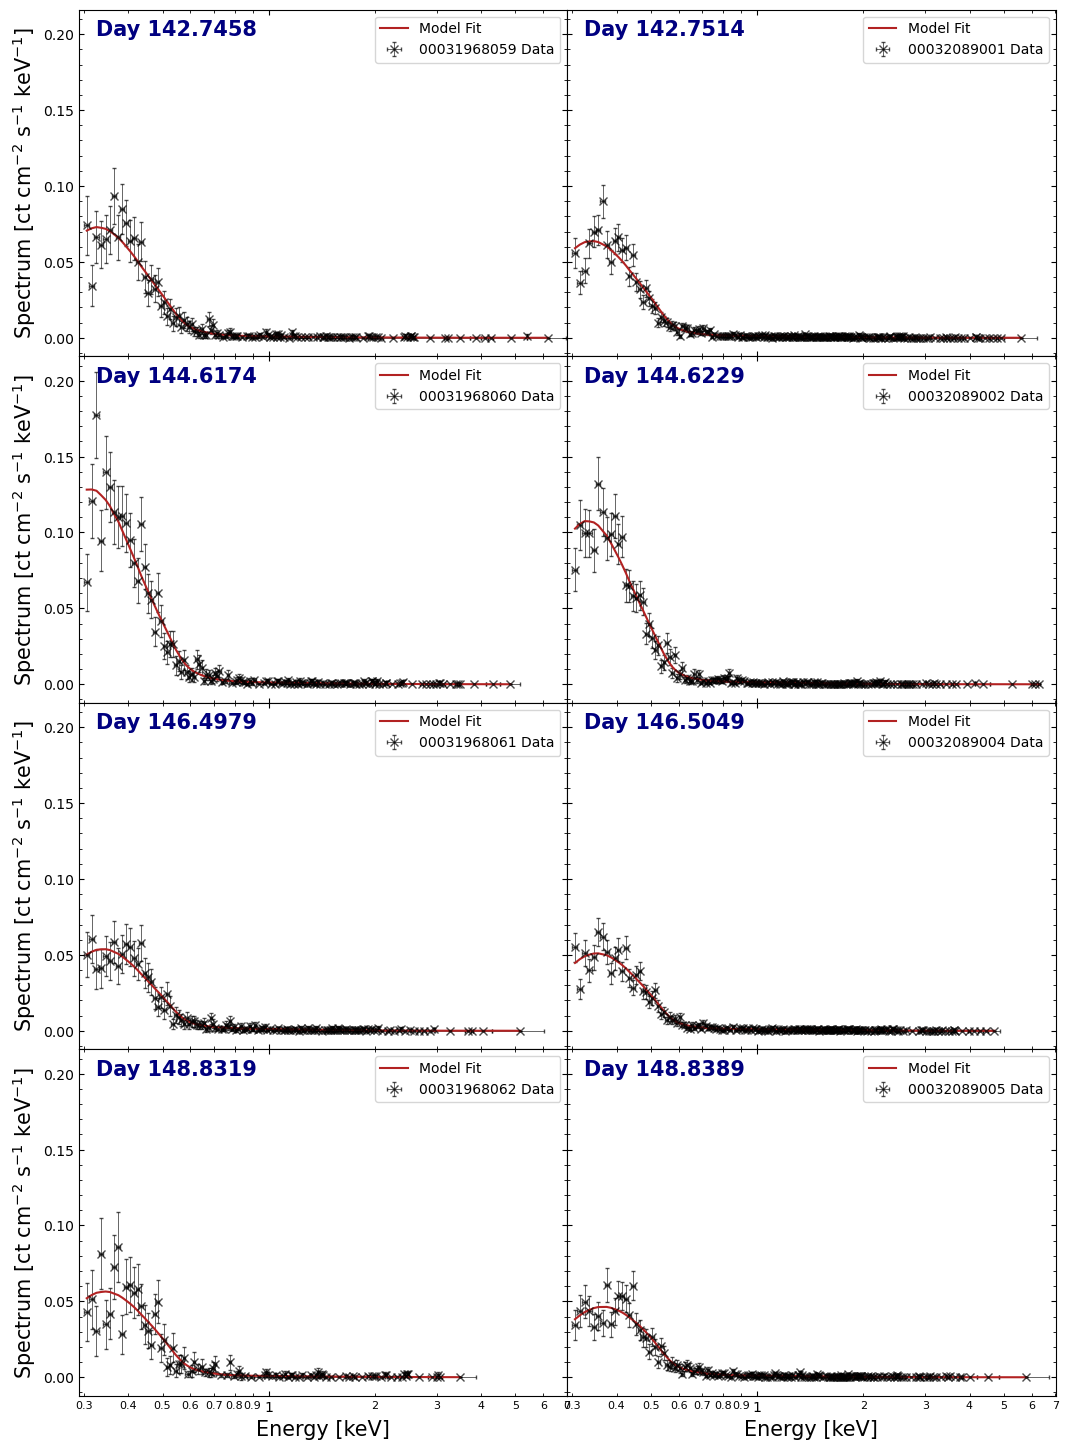

In [37]:
num_sps = len(rel_obsids)
num_cols = 2
num_rows = int(np.ceil(num_sps / num_cols))

fig_side_size = 4.5
width_multi = 1.4

fig, ax_arr = plt.subplots(
    ncols=num_cols,
    nrows=num_rows,
    figsize=((fig_side_size * width_multi) * num_cols, fig_side_size * num_rows),
    sharey=True,
    sharex=True,
)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

ax_ind = 0
for ax_arr_ind, ax in np.ndenumerate(ax_arr):
    if ax_ind >= num_sps:
        ax.set_visible(False)
        continue

    cur_obsid = rel_obsids[ax_ind]
    cur_sp_data = spec_plot_data[cur_obsid]

    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)
    ax.tick_params(which="minor", labelsize=8)

    ax.errorbar(
        cur_sp_data[0],
        cur_sp_data[2],
        xerr=cur_sp_data[1],
        yerr=cur_sp_data[3],
        fmt="kx",
        capsize=1.5,
        label=f"{cur_obsid} Data",
        lw=0.6,
        alpha=0.7,
    )

    if cur_obsid in fit_plot_data:
        ax.plot(
            cur_sp_data[0],
            fit_plot_data[cur_obsid],
            color="firebrick",
            label="Model Fit",
        )

    ax.legend(loc="upper right")

    ax.set_xlim(0.29, 7.01)
    ax.set_xscale("log")

    ax.xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
    ax.xaxis.set_minor_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

    ax.set_xlabel("Energy [keV]", fontsize=15)
    if ax_arr_ind[1] == 0:
        ax.set_ylabel(r"Spectrum [ct cm$^{-2}$ s$^{-1}$ keV$^{-1}$]", fontsize=15)

    day_title = "Day {}".format(obs_day_from_disc_dict[cur_obsid].round(4).value)
    ax.set_title(day_title, y=0.9, x=0.2, fontsize=15, color="navy", fontweight="bold")

    ax_ind += 1

plt.show()

#### Calculating uncertainties on model parameters

Of course, being scientists, we care very much about the uncertainties of our
fitted parameter values - to get a better idea of their confidence ranges, we
can use the `Fit.error()` pyXspec function (which runs the XSPEC `error` command).

For the sake of brevity, we will focus on the errors for the column density (nH), the
black body temperature, and the bremsstrahlung temperature; these are the
first, second, and fourth parameters of the combined model, respectively.

When dealing with multiple data groups however, we must pass the 'global' parameter
index to the error function. Extracting the number of parameters in a single model
instance from pyXspec is simple (and of course, you could just count them), and we
can use that to set up the global parameter index for every column density and
temperature we constrained.

In this case we calculate the 90% confidence range for our parameters (by
passing 2.706 to `error()`).

```{note}
This step can take a few minutes to run!
```

In [38]:
# Retrieve one of the models to help get the number of parameters per model
cur_mod = xs.AllModels(1)
par_per_mod = cur_mod.nParameters

local_pars = {2: "bb_kT", 4: "br_kT"}

# Get the global parameter index for each column density, bb temperature, and
#  br temperature
err_par_ids = [
    str(par_id)
    for oi_ind in range(0, len(rel_obsids))
    for par_id in np.array(list(local_pars.keys())) + (oi_ind * par_per_mod)
]

# Run the error calculation!
xs.Fit.error("2.706 " + " ".join(err_par_ids))

# Retrieve the parameter values and uncertainties for plotting later
indiv_pars = {n: [] for n in local_pars.values()}

for mod_id in range(1, len(rel_obsids) + 1):
    cur_mod = xs.AllModels(mod_id)
    for par_id, par_name in local_pars.items():
        cur_val = cur_mod(par_id).values[0]
        cur_lims_out = cur_mod(par_id).error
        cur_err = [cur_val, cur_val - cur_lims_out[0], cur_lims_out[1] - cur_val]
        indiv_pars[par_name].append(cur_err)

        # Check the error string output by XSPEC's error command and show a warning
        #  if there might be a problem
        if cur_lims_out[2] != "FFFFFFFFF":
            warn(
                f"Error calculation for the {par_name} parameter of model {mod_id} "
                f"indicated a possible problem ({cur_lims_out[2]})",
                stacklevel=2,
            )

# Make sure the parameters are in a numpy array, easier to interact with
#  than lists of lists
indiv_pars = {n: np.array(pars) for n, pars in indiv_pars.items()}

#### Plotting model parameters against time

One of our stated goals was to see if the spectral properties of T Pyx varied over
the course of our observations. As we have fitted models to individual spectra and
calculated the uncertainties on the parameters of those models, we can now plot
the parameter values against time.

Whilst we could plot the parameter values against an absolute time, we instead opt
to plot against the number of days from the outburst's discovery. Those time
deltas were calculated earlier in the notebook, when we were choosing which
observations to use, so we retrieve the relevant values and put them in an array:

In [39]:
spec_days = np.array([obs_day_from_disc_dict[oi].value for oi in rel_obsids])

We are focusing on the black body temperature and the bremsstrahlung
temperature, though the normalizations of the models are also important.

It isn't immediately obvious from the figure below whether there is a significant
change in the parameters over the course of our observations; the temperature
parameters could be jumping between significantly different values, which might be
indicative of a model degeneracy that our individual observations are too poor to
resolve.

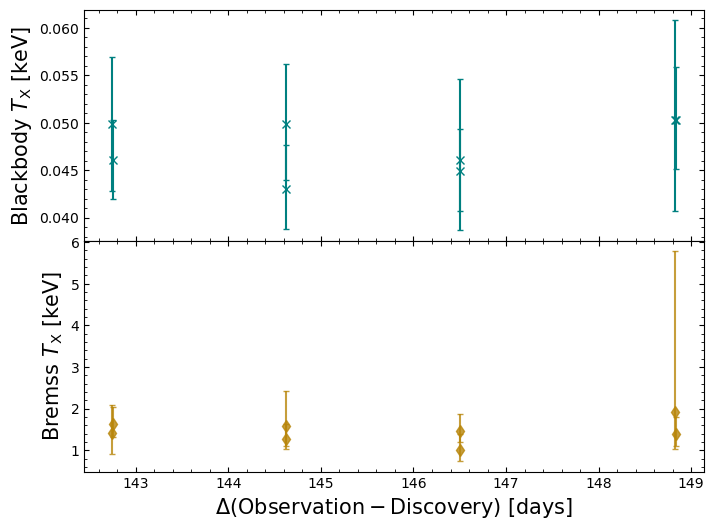

In [40]:
panel_y_size = 3

fig, ax_arr = plt.subplots(
    ncols=1,
    nrows=len(indiv_pars),
    figsize=(8, panel_y_size * len(indiv_pars)),
    sharex=True,
)
plt.subplots_adjust(hspace=0.0)

for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

bb_kt_arr = indiv_pars["bb_kT"]
# Some uncertainties may be negative, in cases where the error
#  calculation encountered issues. This will cause a matplotlib error
#  so we replace negative uncertainties with NaN
bb_kt_arr[np.where(bb_kt_arr < 0)] = np.nan

ax_arr[0].errorbar(
    spec_days,
    bb_kt_arr[:, 0],
    yerr=bb_kt_arr[:, 1:].T,
    fmt="x",
    color="teal",
    capsize=2,
)
ax_arr[0].set_ylabel(r"Blackbody $T_{\rm{X}}$ [keV]", fontsize=15)

br_kt_arr = indiv_pars["br_kT"]
br_kt_arr[np.where(br_kt_arr < 0)] = np.nan

ax_arr[1].errorbar(
    spec_days,
    br_kt_arr[:, 0],
    yerr=br_kt_arr[:, 1:].T,
    fmt="d",
    color="darkgoldenrod",
    capsize=2,
    alpha=0.8,
)
ax_arr[1].set_ylabel(r"Bremss $T_{\rm{X}}$ [keV]", fontsize=15)

if "nH" in indiv_pars:
    nh_arr = indiv_pars["nH"]
    nh_arr[np.where(nh_arr < 0)] = np.nan

    ax_arr[2].errorbar(
        spec_days,
        nh_arr[:, 0],
        yerr=nh_arr[:, 1:].T,
        fmt="p",
        color="firebrick",
        capsize=2,
        alpha=0.8,
    )
    ax_arr[2].set_ylabel(r"nH $10^{22}\:\rm{cm}^{-2}$", fontsize=15)

ax_arr[-1].set_xlabel(r"$\Delta(\rm{Observation-Discovery})$ [days]", fontsize=15)

plt.show()

### Jointly fitting a model to all Swift-XRT spectra

Though we found some success in the previous approach of fitting all spectra
individually, it is clear that the individual observations may not have the
constraining power necessary to fit our chosen model.

[Chomiuk et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...788..130C/abstract) also came to the conclusion
that individual observations were insufficient, and decided to combine Swift-XRT observations
within week-long bins. The generation of combined Swift products is beyond the scope of
this demonstration, so we will attempt something similar by fitting a single model to
all our Swift-XRT spectra. This should significantly increase our constraining
power.

#### Setting up and running a joint fit

Setting up the model for the joint is even easier than before, as we just need to
declare the model, and pyXspec will automatically link all the parameter values:

In [41]:
# Remove all existing models
xs.AllModels.clear()

# Set up the pyXspec model
xs.Model("tbabs*(bb+brems)")

# Setting start values for model parameters
xs.AllModels(1).setPars({1: 1, 2: 0.1, 4: 1.0, 3: 1, 5: 1})

We can then run the fit, calculate uncertainties, and print the XSPEC summary of parameter values.

Once again we calculate parameter uncertainties, though this time we only have to
pass two parameter-IDs, corresponding to black body temperature and bremsstrahlung
temperature:

In [42]:
# Run the model fit
xs.Fit.perform()

# Run the error calculation
xs.Fit.error("2.706 " + " ".join([str(p_ind) for p_ind in list(local_pars.keys())]))

xs.Xset.chatter = 10
xs.AllModels.show()
xs.Xset.chatter = 0


Parameters defined:
Model TBabs<1>(bbody<2> + bremss<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
                           Data group: 1
   1    1   TBabs      nH         10^22    0.136428     +/-  9.70306E-03  
   2    2   bbody      kT         keV      4.69219E-02  +/-  1.13454E-03  
   3    2   bbody      norm                1.06497E-02  +/-  2.52076E-03  
   4    3   bremss     kT         keV      1.43407      +/-  9.06427E-02  
   5    3   bremss     norm                2.70474E-03  +/-  1.87111E-04  
                           Data group: 2
   6    1   TBabs      nH         10^22    0.136428     = p1
   7    2   bbody      kT         keV      4.69219E-02  = p2
   8    2   bbody      norm                1.06497E-02  = p3
   9    3   bremss     kT         keV      1.43407      = p4
  10    3   bremss     norm                2.70474E-03  = p5
                           Data group: 3
  11    1   TBabs      nH         10^22    0.136428  

#### Joint fit results

Finally, we will retrieve the value and uncertainty results of the joint fit:

In [43]:
cur_mod = xs.AllModels(1)

for par_id, par_name in local_pars.items():
    cur_val = cur_mod(par_id).values[0]
    cur_lims_out = cur_mod(par_id).error
    cur_err = np.array([cur_val - cur_lims_out[0], cur_lims_out[1] - cur_val])

    if cur_lims_out[2] != "FFFFFFFFF":
        warn(
            f"Error calculation for the {par_name} parameter "
            f"indicated a possible problem ({cur_lims_out[2]})",
            stacklevel=2,
        )

    if par_name == "nH":
        u_str = r" $\times 10^{22}$ cm$^{-2}$"
    elif par_name == "bb_kT":
        cur_val *= 1000
        cur_err *= 1000
        u_str = " eV"
    elif par_name == "br_kT":
        u_str = " keV"

    r_str = f"{par_name} = ${cur_val:.3f}_{{-{cur_err[0]:.3f}}}^{{+{cur_err[1]:.3f}}}$"
    full_out = r_str + u_str

    display(Markdown(full_out))

bb_kT = $46.922_{-1.915}^{+1.969}$ eV

br_kT = $1.434_{-0.131}^{+0.151}$ keV

From this we can see that the temperature of the black body component is significantly
lower than the bremsstrahlung temperature. This finding, and the values of the
temperatures that we measure, are broadly consistent with the results for the
day 142-149 period results presented by [Chomiuk et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...788..130C/abstract).

## About this notebook

Author: David Turner, HEASARC Staff Scientist

Author: Peter Craig, Michigan State University Research Associate

Updated On: 2025-12-23

### Additional Resources

### Acknowledgements

David Turner thanks Peter Craig (Michigan State University) for volunteering one
of his favourite Swift-XRT sources for this demonstration.

### References

[Chomiuk et al. (2014) - THE 2011 OUTBURST OF RECURRENT NOVA T Pyx: X-RAY OBSERVATIONS EXPOSE THE WHITE DWARF MASS AND EJECTION DYNAMICS](https://ui.adsabs.harvard.edu/abs/2014ApJ...788..130C/abstract)